In [1]:
# import libraries
import numpy as np
import pandas as pd
import dionysus as d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import math
import random
import numpy as np

%matplotlib widget

In [2]:
# define the classes
class Point:
    id: int
    coord: np.ndarray
    dominant: int
    value: float
    tissue: bool
    valid: bool
    # edges_belonged: set[int] = set()
    # triangles_belonged: set[int] = set()
    # tets_belonged: set[int] = set()

point_list: list[Point] = []
edge_set: set[tuple[int]] = set()
triangle_set: set[tuple[int]] = set()
tetrahedron_set: set[tuple[int]] = set()


Run either data import or test data generation code block, but not both

In [3]:
# load from data files
# points_data = pd.read_csv("points.csv")
# tets_data = pd.read_csv("tets.csv")

In [4]:
# generate test data
# torus parameters
R = 4
r = 0.5
num_points = 10000


width = 2 * (R + r)
height = 2 * r


# test if a point is inside the torus
def torus(x, y, z):
    return (R - np.sqrt(x**2 + y**2)) ** 2 + z**2 < r**2


# generate random points in the bounding box of the torus, with a random value appended
points = np.array([p for p in np.random.rand(num_points, 3) * [width, width, height] - [R + r, R + r, r] if torus(*p)])

# delauany tetrahedralization
tets_data = pd.DataFrame(Delaunay(points).simplices)

# generate random values for each point
values = pd.DataFrame(np.concatenate([np.random.rand(len(points), 1), np.zeros((len(points), 1))], axis=1))
points_data = pd.concat([pd.DataFrame(points), values], axis=1)

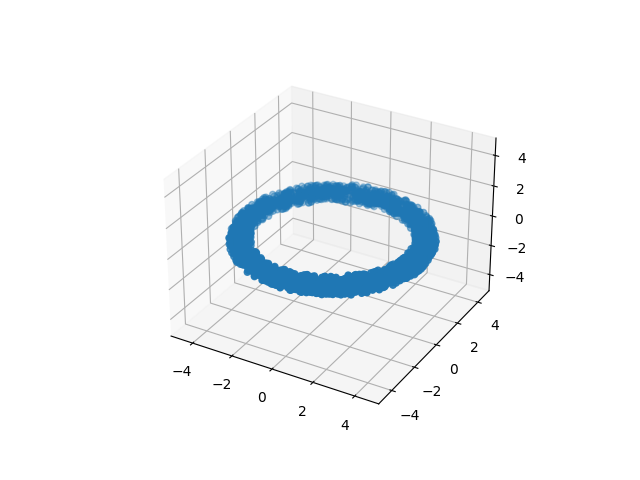

In [5]:
# plot the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_data.iloc[:, 0].to_numpy(), points_data.iloc[:, 1].to_numpy(), points_data.iloc[:, 2].to_numpy())

x_limits = ax.get_xlim3d()
y_limits = ax.get_ylim3d()
z_limits = ax.get_zlim3d()

x_range = abs(x_limits[1] - x_limits[0])
x_middle = np.mean(x_limits)
y_range = abs(y_limits[1] - y_limits[0])
y_middle = np.mean(y_limits)
z_range = abs(z_limits[1] - z_limits[0])
z_middle = np.mean(z_limits)

plot_radius = 0.5 * max([x_range, y_range, z_range])

ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

plt.show()

In [6]:
num_materials = points_data.shape[1] - 3

for i, row in points_data.iterrows():
    point = Point()
    point.id = i
    point.coord = row.iloc[:3]
    values = row.iloc[3:]
    point.dominant = np.argmax(values)
    values_sorted = sorted(values)
    point.value = values_sorted[-1] - values_sorted[-2]
    point.tissue = point.dominant != num_materials - 1
    point.valid = not pd.isna(point.value) and point.tissue
    point_list.append(point)

edge_combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
triangle_combinations = [
    (0, 1, 2),
    (0, 1, 3),
    (0, 2, 3),
    (1, 2, 3),
]


def same_material(point_indices):
    return all([point_list[point].dominant == point_list[point_indices[0]].dominant for point in point_indices])


def all_valid(point_indices):
    return all([point_list[point].valid for point in point_indices])


for i, tet in tets_data.iterrows():
    edges = [sorted([tet[x[0]], tet[x[1]]]) for x in edge_combinations]
    [edge_set.add(tuple(x)) for x in edges if same_material(x) and all_valid(x)]
    triangles = [sorted([tet[x[0]], tet[x[1]], tet[x[2]]]) for x in triangle_combinations]
    [triangle_set.add(tuple(x)) for x in triangles if same_material(x) and all_valid(x)]
    if same_material(tet) and all_valid(tet):
        tetrahedron_set.add(tuple(sorted(tet)))

In [7]:

valid_point_list = [point for point in point_list if point.valid]

def get_time(point_indices):
    return 1 - min([point_list[point].value for point in point_indices])

# group the points by material
points_by_material = [[] for _ in range(num_materials)]
edges_by_material = [[] for _ in range(num_materials)]
triangles_by_material = [[] for _ in range(num_materials)]
tets_by_material = [[] for _ in range(num_materials)]
for point in valid_point_list:
    points_by_material[point.dominant].append(([point.id], 1 - point.value))
for edge in edge_set:
    edges_by_material[point_list[edge[0]].dominant].append((list(edge), get_time(edge)))
for triangle in triangle_set:
    triangles_by_material[point_list[triangle[0]].dominant].append((list(triangle), get_time(triangle)))
for tet in tetrahedron_set:
    tets_by_material[point_list[tet[0]].dominant].append((list(tet), get_time(tet)))


Material 0 has 2432 points, 17958 edges, 30818 triangles, 15291 tets


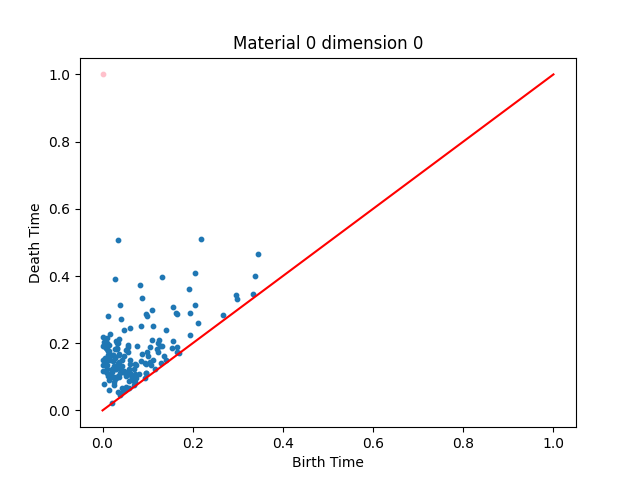

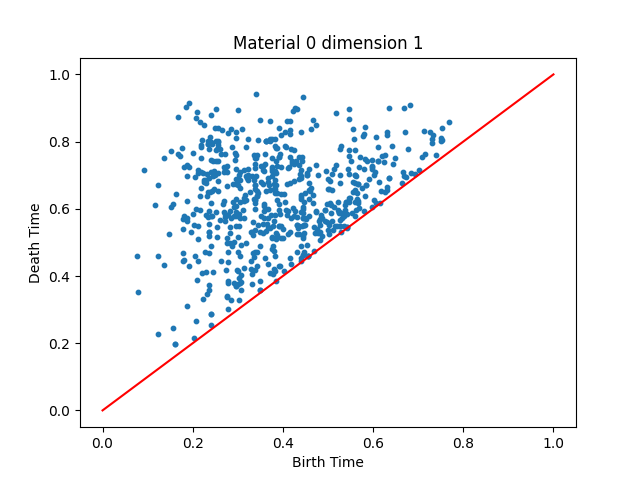

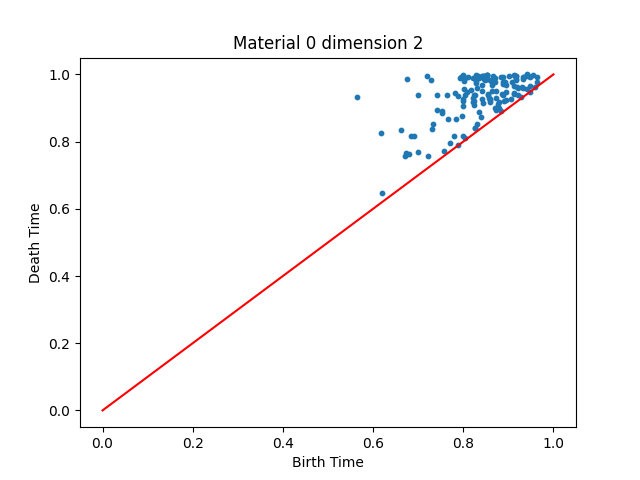

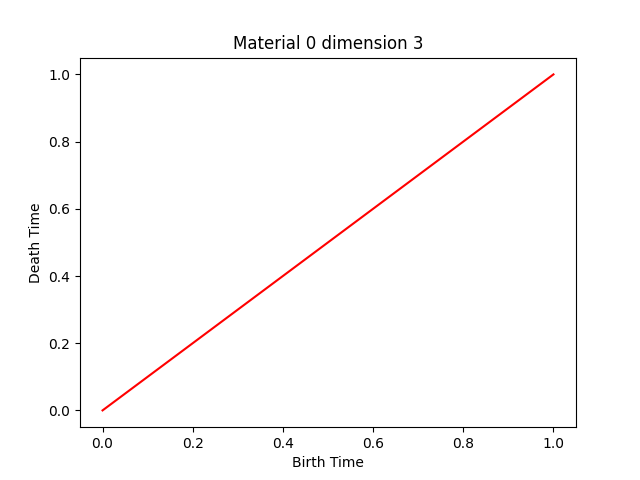

Material 1 has no points


In [8]:
# iterate through the materials
for material in range(num_materials):
    if len(points_by_material[material]) == 0:
        print(f"Material {material} has no points")
        continue

    print(f"Material {material} has {len(points_by_material[material])} points, {len(edges_by_material[material])} edges, {len(triangles_by_material[material])} triangles, {len(tets_by_material[material])} tets")

    simplices = []
    simplices.extend(points_by_material[material])
    simplices.extend(edges_by_material[material])
    simplices.extend(triangles_by_material[material])
    simplices.extend(tets_by_material[material])

    filtration = d.Filtration()
    for vertices, time in simplices:
        filtration.append(d.Simplex(vertices, time))
    filtration.sort()

    ph_matrix = d.homology_persistence(filtration)
    diagrams = d.init_diagrams(ph_matrix, filtration)

    # for i, line in enumerate(ph_matrix):
    #     print(i, line)
        
    for i, diagram in enumerate(diagrams):
        plt.figure()
        plt.title(f"Material {material} dimension {i}")
        filtered_diagram = [pt for pt in diagram if pt.birth < pt.death]
        # d.plot.plot_diagram(filtered_diagram, show=True)

        # Extract birth and death times for plotting
        finite_birth_times = [pt.birth for pt in filtered_diagram if pt.death != float('inf')]
        finite_death_times = [pt.death for pt in filtered_diagram if pt.death != float('inf')]
        infinite_birth_times = [pt.birth for pt in filtered_diagram if pt.death == float('inf')]
        infinite_death_times = [1.0 for pt in filtered_diagram if pt.death == float('inf')]
        
        # Plot using plt.scatter to control dot sizes
        plt.scatter(finite_birth_times, finite_death_times, s=10) 
        plt.scatter(infinite_birth_times, infinite_death_times, s=10, color='pink')
        plt.plot([0, 1], [0, 1], 'r')
        plt.xlabel('Birth Time')
        plt.ylabel('Death Time')
        plt.show()

        # for pt in diagram:
        #     print(i, pt.birth, pt.death, pt.data)

In [29]:

for i in range(num_materials):
    if len(points_by_material[i]) == 0:
        print(f"Material {i} has no points")
        continue
    vertices = [list(point_list[point[0][0]].coord) for point in points_by_material[i]]
    intensities = [point[1] for point in points_by_material[i]]
    faces = [triangle[0] for triangle in triangles_by_material[i]]

    x, y, z = zip(*vertices)
    i, j, k = zip(*faces)

    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, intensity=intensities, colorscale=[[0, 'navy'], [0.25, 'cyan'], [0.5, 'lime'], [0.75, 'yellow'], [1, 'red']], opacity=0.50)])
    fig.update_layout(scene=dict(
        xaxis=dict(range=[-plot_radius, plot_radius]),
        yaxis=dict(range=[-plot_radius, plot_radius]),
        zaxis=dict(range=[-plot_radius, plot_radius]),
        aspectmode='manual',
        title_text=f"Material {i}"
    ))
    fig.show()



ValueError: Invalid property specified for object of type plotly.graph_objs.layout.Scene: 'title'

Did you mean "xaxis"?

    Valid properties:
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.scene.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.scene.annotationdefaults), sets
            the default property values to use for elements of
            layout.scene.annotations
        aspectmode
            If "cube", this scene's axes are drawn as a cube,
            regardless of the axes' ranges. If "data", this scene's
            axes are drawn in proportion with the axes' ranges. If
            "manual", this scene's axes are drawn in proportion
            with the input of "aspectratio" (the default behavior
            if "aspectratio" is provided). If "auto", this scene's
            axes are drawn using the results of "data" except when
            one axis is more than four times the size of the two
            others, where in that case the results of "cube" are
            used.
        aspectratio
            Sets this scene's axis aspectratio.
        bgcolor

        camera
            :class:`plotly.graph_objects.layout.scene.Camera`
            instance or dict with compatible properties
        domain
            :class:`plotly.graph_objects.layout.scene.Domain`
            instance or dict with compatible properties
        dragmode
            Determines the mode of drag interactions for this
            scene.
        hovermode
            Determines the mode of hover interactions for this
            scene.
        uirevision
            Controls persistence of user-driven changes in camera
            attributes. Defaults to `layout.uirevision`.
        xaxis
            :class:`plotly.graph_objects.layout.scene.XAxis`
            instance or dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.scene.YAxis`
            instance or dict with compatible properties
        zaxis
            :class:`plotly.graph_objects.layout.scene.ZAxis`
            instance or dict with compatible properties
        
Did you mean "xaxis"?

Bad property path:
title
^^^^^